# Inversión FASE MT - RHOA SEDT

Importar librerías

In [66]:
import os
import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import tarfile
from scipy.constants import mu_0

#MTpy
from pathlib import Path
from mtpy import MT, MTData, MTCollection
import h5py
import sys

#SimPEG
from simpeg.electromagnetics import natural_source as nsem
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model, download, mkvc
from discretize import TensorMesh
from simpeg import (
    maps,
    data,
    data_misfit, 
    regularization,
    optimization,
    inverse_problem,
    inversion, 
    directives,
    utils,
)

#mpl.rcParams.update({"font.size": 16})
from ipywidgets import interact, widgets
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tkinter import Tk, Button, filedialog

import pygimli as pg
from pygimli.physics import em

mpl.rcParams.update({"font.size": 16})
write_output = False

In [2]:
datas = em.readusffile('DatosMT_TDEM/20240901_081805_640_Station2.usf')


NSWEEPS = len(datas)
COILSIZE1=35 #0.5×0.5 en el RC-5
COILSIZE2=1400 # 10×10 en la RC-200

dbdts1, dbdts2, dbdts4, dbdts5= [], [], [], []
tiempo_1, tiempo_2, tiempo_4, tiempo_5= [], [], [], []

for sweep in datas:
    if sweep['CURRENT'] != 0:
        channel = int(sweep['CHANNEL'])
        voltage = sweep['VOLTAGE']
        current = sweep['CURRENT']
        time = sweep['TIME']
        coil_size = sweep['COIL_SIZE']

        if channel == 1:
            dbdts1.append(voltage)
            tiempo_1.append(time)
        elif channel == 2:
            dbdts2.append(voltage)
            tiempo_2.append(time)
        elif channel == 4:
            dbdts4.append(voltage)
            tiempo_4.append(time)
        elif channel == 5:
            dbdts5.append(voltage)
            tiempo_5.append(time)

In [3]:
# RC-5 LM
dbdt_1 = np.array(dbdts1)
dbdt_RC5_Low= np.nanmean(dbdt_1,axis=0)

# RC-5 HM
dbdt_2 = np.array(dbdts2)
dbdt_RC5_High= np.nanmean(dbdt_2,axis=0)

# RC-200 LM
dbdt_4 = np.array(dbdts4)
dbdt_RC200_Low= np.nanmean(dbdt_4,axis=0)

# RC-200 HM
dbdt_5 = np.array(dbdts5)
dbdt_RC200_High= np.nanmean(dbdt_5,axis=0)

# Calcular el promedio de las LM
dbdt_low = np.mean([dbdt_RC5_Low, dbdt_RC200_Low], axis=0)

# Calcular el promedio de las HM
dbdt_high = np.mean([dbdt_RC5_High, dbdt_RC200_High], axis=0)

# Tiempo LM
tiempo_LM = np.array(tiempo_1)
tiempo_LM= np.nanmean(tiempo_LM,axis=0)

# Tiempo HM
tiempo_HM = np.array(tiempo_2)
tiempo_HM= np.nanmean(tiempo_HM,axis=0)

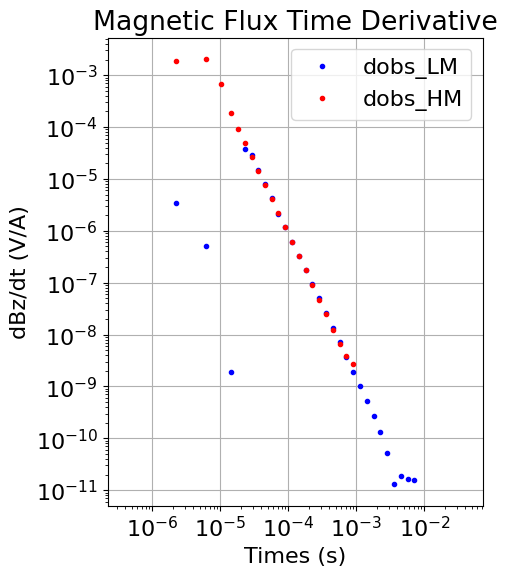

In [4]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])

ax.loglog(tiempo_LM, dbdt_low, "b.",  label='dobs_LM')
ax.loglog(tiempo_HM, dbdt_high, "r.", label='dobs_HM')

ax.set_xlim([tiempo_LM.min()/10, 10*tiempo_LM.max()])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [5]:
dobs_LM =  np.array([2.86370775e-05,  1.50016875e-05,
        8.10113420e-06,  4.22708080e-06,  2.10277300e-06,  1.18768855e-06,
        6.19675405e-07,  3.33383780e-07,  1.77543795e-07,  9.36266230e-08,
        4.97765655e-08,  2.62341625e-08,  1.35167765e-08,  7.15538870e-09,
        3.75073009e-09,    1.02464738e-09,  5.29192750e-10,
        2.68062288e-10,  1.33956919e-10,  5.12430026e-11])

In [6]:
dobs_LM.shape

(20,)

In [7]:
time_LM= np.array([2.86900e-05, 3.61900e-05, 4.51900e-05, 5.66900e-05,
       7.11900e-05, 8.96900e-05, 1.13190e-04, 1.42190e-04, 1.79190e-04,
       2.25690e-04, 2.83690e-04, 3.57190e-04, 4.49690e-04, 5.66190e-04,
       7.12690e-04, 8.97190e-04, 1.12969e-03, 1.42219e-03, 1.79019e-03,
       2.25369e-03])

In [8]:
time_LM.shape

(20,)

In [9]:
dobs_HM = np.array([ 2.06485925e-03, 6.60927970e-04, 1.83625815e-04,
       9.10194515e-05, 5.01903610e-05, 2.67417240e-05, 1.41783515e-05,
       7.67913195e-06, 4.12543320e-06, 2.16983255e-06, 1.16258334e-06,
       6.14806370e-07, 3.30294940e-07, 1.77524850e-07, 9.21739145e-08,
       4.60998530e-08, 2.44745749e-08, 1.24790119e-08, 6.66146595e-09,
       3.93205030e-09])

In [10]:
dobs_HM.shape

(20,)

In [11]:
time_HM = np.array([ 6.1900e-06, 1.0190e-05, 1.4190e-05, 1.8190e-05,
       2.2690e-05, 2.8690e-05, 3.6190e-05, 4.5190e-05, 5.6690e-05,
       7.1190e-05, 8.9690e-05, 1.1319e-04, 1.4219e-04, 1.7919e-04,
       2.2569e-04, 2.8369e-04, 3.5719e-04, 4.4969e-04, 5.6619e-04,
       7.1269e-04])

In [12]:
time_HM.shape

(20,)

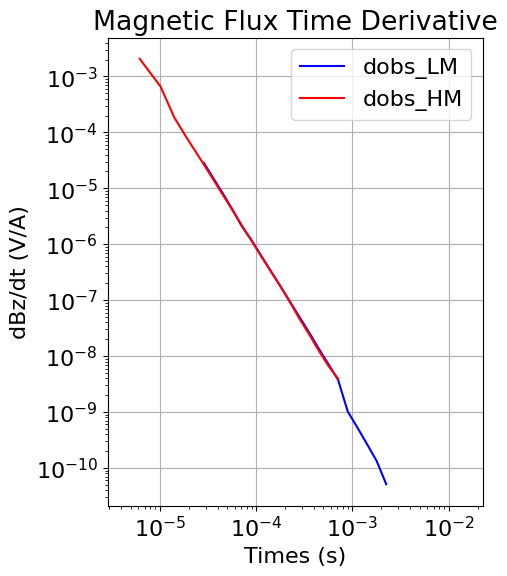

In [13]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])

ax.loglog(time_LM, dobs_LM, "b-",  label='dobs_LM')
ax.loglog(time_HM, dobs_HM, "r-", label='dobs_HM')

ax.set_xlim([time_LM.min()/10, 10*time_LM.max()])
#ax.set_ylim([1e-12, 1e-3])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()


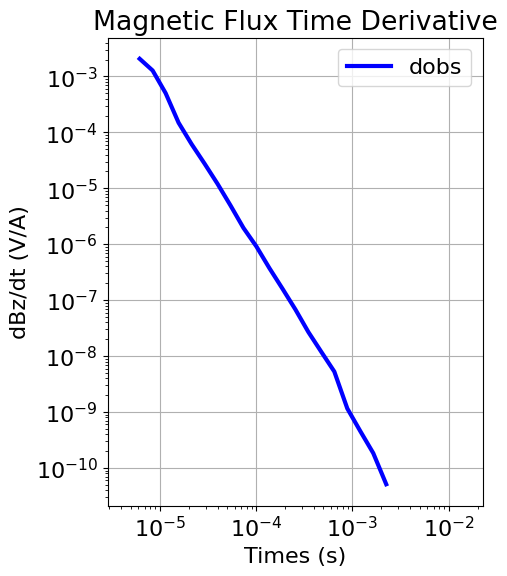

In [14]:
from scipy import interpolate
x = np.concatenate((time_HM, time_LM))
y = np.concatenate((dobs_HM, dobs_LM))
f = interpolate.interp1d(x, y, fill_value="extrapolate")

tiempo = np.logspace(np.log10(np.min(time_HM)), np.log10(np.max(time_LM)), 20)
dobs = f(tiempo)   # use interpolation function returned by `interp1d`



fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(tiempo, dobs, "b-", lw=3, label='dobs')
ax.set_xlim([time_LM.min()/10, 10*time_LM.max()])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [15]:
from pygimli.physics.em import rhoafromU

In [16]:
rhoa_TDEM = rhoafromU(U= dobs, t= tiempo, Tx= 1600, Rx= 1)

In [18]:
rhoa_TDEM = np.array([ 74.72282175,  75.60961936,  80.98789144,  92.1940653 ,
       101.86249633,  97.83203607, 108.82869354, 110.34720837,
       116.92407455, 123.32224027, 129.8174898 , 132.71769025,
       139.53839719, 159.85016202, 162.20665554, 170.43943339,
       180.65205292, 235.55407531, 309.96742717, 341.34022977,])

In [19]:
rhoa_TDEM.shape

(20,)

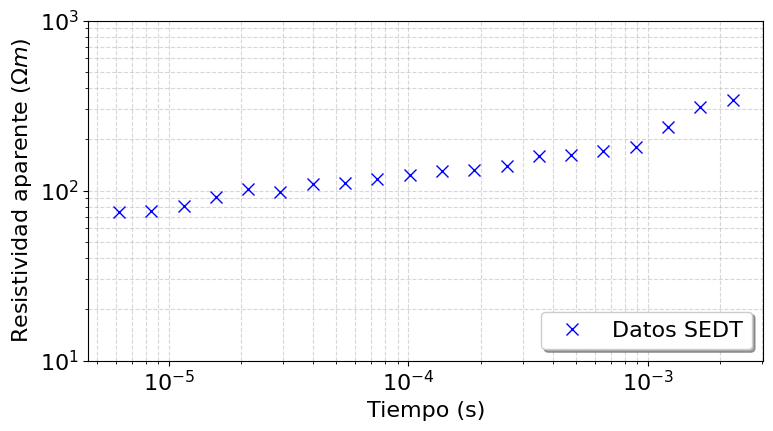

In [20]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(tiempo, rhoa_TDEM, "b-",marker="x", markersize=8, lw=2, linestyle='none', label='Datos SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**1, 10**3])
#ax.set_xlim([10**-5.5, 10**-1.5])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)
plt.savefig("SEDTPiedecuesta.svg", dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [21]:
edi_path = Path("DatosMT_TDEM/DATOS_MT(es_el_2)") # Ruta de la carpeta con los edis procesados

mc = MTCollection()
mc.open_collection(Path("DatosMT_TDEM/DATOS_MT(es_el_2)/"+"collection_crudo.h5"))  # Ruta para guardar el h5 crudo

In [22]:
# Cargar los edis al MTColecction

for edi_filename in mc.make_file_list(edi_path, file_types=["edi"]):
    mt_object = MT(edi_filename) # Crea un objeto MT de cada edi
    mt_object.read() # Lee el objeto

    # Actualizar el id del survey
    mt_object.survey_metadata.id = "edi" 
    mc.add_tf(mt_object) # Agrega los edi a la colección

25:03:31T11:35:55 | WARNING | line:256 |mtpy.core.mt_collection | add_tf | If you are adding multiple transfer functions, suggest making a list of transfer functions first then adding the list using mt_collection.add_tf([list_of_tfs]). Otherwise adding transfer functions one by one will be slow.
25:03:31T11:35:55 | INFO | line:399 |mtpy.core.mt_collection | _from_mt_object | added edi.P


In [23]:
mc.master_dataframe.head()

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,P,edi,6.963111,-73.048167,958.253,P,none,True,True,True,0.0001,728.177786,<HDF5 object reference>,<HDF5 object reference>


25:03:31T11:35:55 | WARNING | line:311 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID P. Suggest setting survey, otherwise returning the TF from survey edi.


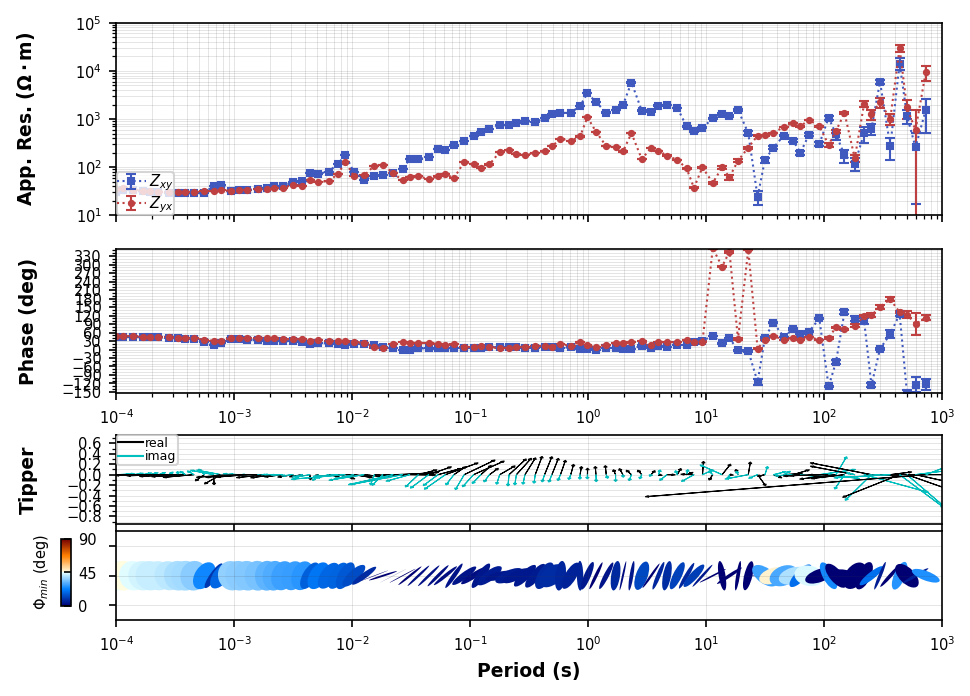

In [24]:
try:
    mc.plot_mt_response("P") 
except:
    pass

In [25]:
sondeo = mc.get_tf("P", survey="edi") # sondeo a invertir
print(sondeo)

Station: P
--------------------------------------------------
	Survey:            edi
	Project:           None
	Acquired by:       GIDCO SAS
	Acquired date:     2022-11-06
	Latitude:          6.963
	Longitude:         -73.048
	Elevation:         958.253
	Declination:   
		Value:     0.0
		Model:     WMM
	Coordinate System: geographic
	Impedance:         True
	Tipper:            True
	N Periods:     92
	Period Range:
		Min:   1.00000E-04 s
		Max:   7.28178E+02 s
	Frequency Range:
		Min:   1.37329E-03 Hz
		Max:   1.00000E+04 Hz


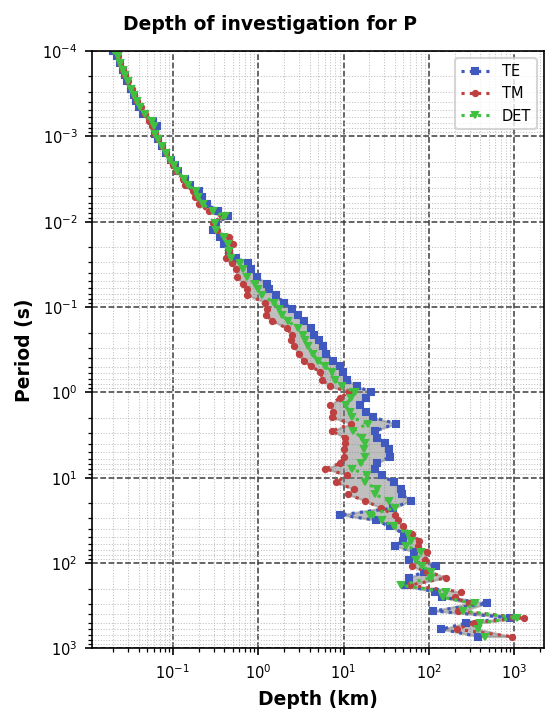

Plotting PlotPenetrationDepth1D

In [26]:
sondeo.plot_depth_of_penetration()

In [27]:
frecuencias = np.array(sondeo.Z.frequency) # frecuencias
rho_app_xy = np.array(sondeo.Z.res_xy) # resistividad aparente
rho_app_yx = np.array(sondeo.Z.res_yx) # resistividad aparente
phase_xy = np.array(sondeo.Z.phase_xy) # fase
phase_yx = np.array(sondeo.Z.phase_yx) # fase
rho_app = np.array(sondeo.Z.res_det)
phase = np.array(sondeo.Z.phase_det)

In [28]:
mc.close_collection()

25:03:31T11:35:58 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing Datos2.MT_TDEM\DATOS_MT(es_el_2)\collection_crudo.h5


In [29]:
rho_app = rho_app[:67]
phase = phase[:67]
frecuencias = frecuencias[:67]

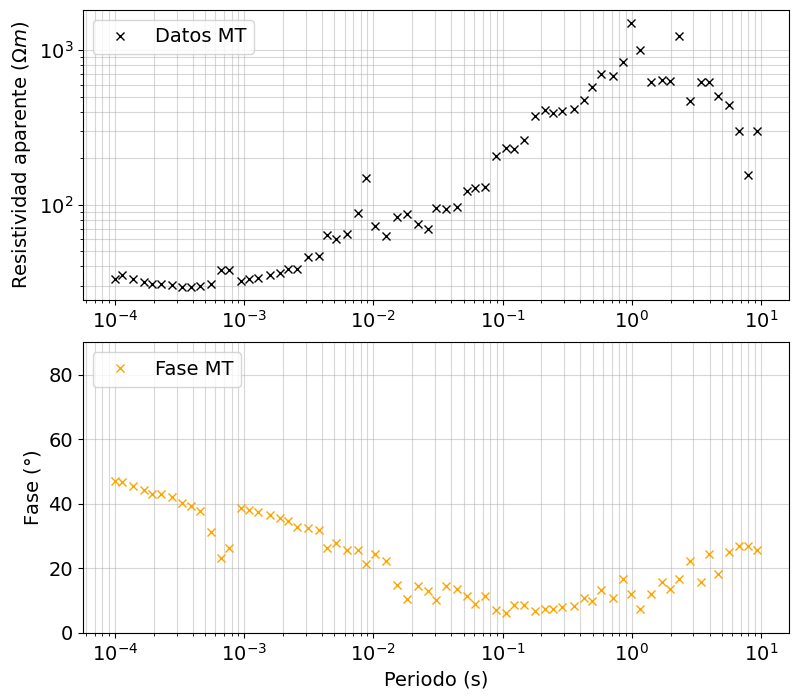

In [30]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Crear figura con 2 filas y 1 columna
fig = plt.figure(figsize=(8, 7))  # Ajusta el alto (6) para que quepan ambas gráficas
gs = gridspec.GridSpec(2, 1, figure=fig)  # 2 filas, 1 columna

# --- Gráfica 1: Resistividad ---
ax1 = fig.add_subplot(gs[0, 0])  # Primera fila
#ax1.loglog(1/frecuencias, rho_app_xy, color='blue', label='XY', marker="x", lw=2, linestyle='none')
#ax1.loglog(1/frecuencias, rho_app_yx, color='red', label='YX', marker="x", lw=2, linestyle='none')
ax1.loglog(1/frecuencias, rho_app, color='black', label='Datos MT', marker="x", lw=2, linestyle='none')
ax1.grid(True, which='both', alpha=0.5)
ax1.set_ylabel(r"Resistividad aparente ($\Omega m$)", fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.legend(loc='upper left', fontsize=14)

# --- Gráfica 2: Fase ---
ax2 = fig.add_subplot(gs[1, 0])  # Segunda fila
#ax2.semilogx(1/frecuencias, phase_xy, color='blue', label='XY', marker="x", lw=2, linestyle='none')
#ax2.semilogx(1/frecuencias, phase_yx + 180, color='red', label='YX', marker="x", lw=2, linestyle='none')
ax2.semilogx(1/frecuencias, phase, color='orange', label='Fase MT', marker="x", lw=2, linestyle='none')
ax2.grid(True, which='both', alpha=0.5)
ax2.set_ylabel("Fase ($\degree$)", fontsize=14)
ax2.set_xlabel("Periodo (s)", fontsize=14)
ax2.set_ylim(0, 90)
ax2.tick_params(axis='both', labelsize=14)
ax2.legend(loc='upper left', fontsize=14)
plt.savefig("DatosMTPiedecuesta.png", dpi=300, bbox_inches='tight', format='png')


plt.tight_layout()  # Ajusta el espaciado entre gráficas
plt.show()

In [31]:
rho_app = np.array([  33.07149358,   35.23075871,   33.21448226,   31.85567078,
         30.87836648,   30.51108972,   30.21612263,   29.41831908,
         29.28629961,   29.72734428,   30.80710223,   31.72913175,
         31.00271292,   32.05820514,   32.85665808,   33.67056353,
         34.98000698,   36.06980897,   38.38498365,   38.35572872,
         45.85192777,   46.41866907,   64.04639332,   60.18871907,
         64.74730593,   88.86298233,  90.03848903,   73.12504169,
         63.15889613,   83.02672608,   86.95895661,   74.9666748 ,
         69.42338002,   95.15318156,   94.40581703,   96.74270917,
        122.73368185,  127.51109142,  130.93333614,  207.80228385,
        231.49204593,  229.57072543,  264.07215985,  375.18725956,
        407.4958167 ,  392.41972369,  405.04933265,  417.56696097,
        474.79689106,  580.98313408,  706.23618726,  685.06112436,
        837.19768437, 1000.27531709, 1001.01574065,  900.95245127,
        720.15497682,  700.65535865, 700.53644838,  650.7917124 ,
        621.4066394 ,  620.15513945,  503.85107348,  441.63344169,
        320.95484933,  300.72728819,  298.31951514])

In [32]:
phase = np.array([47.07467211, 46.85173264, 45.633938  , 44.17859495, 43.16994081,
       43.09785331, 42.22387455, 40.31218952, 39.16178895, 37.87973731,
       38.64499545, 38.64499545, 38.64499545, 38.64499545, 38.01972489,
       37.45911854, 36.66891188, 35.65581563, 34.60090482, 32.85008016,
       32.50953999, 31.76463512, 26.39377155, 27.89388055, 25.68181576,
       25.70364682, 21.39647192, 24.42876929, 22.35446902, 14.96662976,
       10.56443387, 14.46427106, 13.04194084, 10.21759044, 14.63602413,
       13.43391325, 11.45792964,  9.04372574, 11.28440295,  6.96338672,
        6.20068145,  8.57566208,  8.67668481,  6.75380668,  7.3670126 ,
        7.40762902,  7.9187619 ,  8.38174987, 10.93532096,  9.80810187,
       13.14412349, 10.80309967, 16.75896007, 12.18497373,  7.41529244,
       12.0347244 , 15.88972016, 13.69630022, 16.71649834, 22.30276598,
       15.7370824 , 24.39138129, 18.34620329, 24.93301892, 26.97628472,
       26.87180588, 25.74662701])


In [33]:
frecuencias

array([1.000000e+04, 8.800000e+03, 7.200000e+03, 6.000000e+03,
       5.200000e+03, 4.400000e+03, 3.600000e+03, 3.000000e+03,
       2.600000e+03, 2.200000e+03, 1.800000e+03, 1.500000e+03,
       1.300000e+03, 1.058824e+03, 9.176471e+02, 7.764706e+02,
       6.352941e+02, 5.294118e+02, 4.588235e+02, 3.882353e+02,
       3.176471e+02, 2.647059e+02, 2.294118e+02, 1.941176e+02,
       1.588235e+02, 1.323529e+02, 1.147059e+02, 9.705882e+01,
       7.941176e+01, 6.500000e+01, 5.500000e+01, 4.500000e+01,
       3.750000e+01, 3.250000e+01, 2.750000e+01, 2.250000e+01,
       1.875000e+01, 1.625000e+01, 1.375000e+01, 1.125000e+01,
       9.375000e+00, 8.125000e+00, 6.875000e+00, 5.625000e+00,
       4.687500e+00, 4.062500e+00, 3.437500e+00, 2.812500e+00,
       2.343750e+00, 2.031250e+00, 1.718750e+00, 1.406250e+00,
       1.171875e+00, 1.015625e+00, 8.593750e-01, 7.031250e-01,
       5.859375e-01, 5.078125e-01, 4.296875e-01, 3.515625e-01,
       2.929688e-01, 2.539063e-01, 2.148438e-01, 1.7578

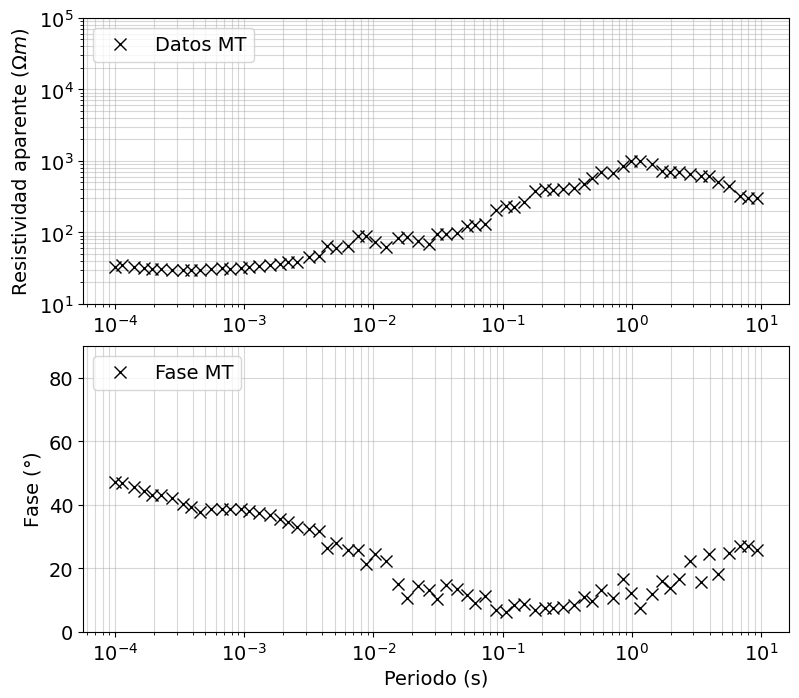

In [34]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Crear figura con 2 filas y 1 columna
fig = plt.figure(figsize=(8, 7))  # Ajusta el alto (6) para que quepan ambas gráficas
gs = gridspec.GridSpec(2, 1, figure=fig)  # 2 filas, 1 columna

# --- Gráfica 1: Resistividad ---
ax1 = fig.add_subplot(gs[0, 0])  # Primera fila
#ax1.loglog(1/frecuencias, rho_app_xy, color='blue', label='XY', marker="x", lw=2, linestyle='none')
#ax1.loglog(1/frecuencias, rho_app_yx, color='red', label='YX', marker="x", lw=2, linestyle='none')
ax1.loglog(1/frecuencias, rho_app, color='black', label='Datos MT', marker="x",markersize=8, lw=2, linestyle='none')
ax1.set_ylim([10**1, 10**5])
ax1.grid(True, which='both', alpha=0.5)
ax1.set_ylabel(r"Resistividad aparente ($\Omega m$)", fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.legend(loc='upper left', fontsize=14)

# --- Gráfica 2: Fase ---
ax2 = fig.add_subplot(gs[1, 0])  # Segunda fila
#ax2.semilogx(1/frecuencias, phase_xy, color='blue', label='XY', marker="x", lw=2, linestyle='none')
#ax2.semilogx(1/frecuencias, phase_yx + 180, color='red', label='YX', marker="x", lw=2, linestyle='none')
ax2.semilogx(1/frecuencias, phase, color='k', label='Fase MT', marker="x", markersize=8, lw=2, linestyle='none')
ax2.grid(True, which='both', alpha=0.5)
ax2.set_ylabel("Fase ($\degree$)", fontsize=14)
ax2.set_xlabel("Periodo (s)", fontsize=14)
ax2.set_ylim(0, 90)
ax2.tick_params(axis='both', labelsize=14)
ax2.legend(loc='upper left', fontsize=14)
plt.savefig("MTPiedecuesta.svg", dpi=300, bbox_inches='tight', format='svg')


plt.tight_layout()  # Ajusta el espaciado entre gráficas
plt.show()

In [35]:
f1 = 0.194 / tiempo

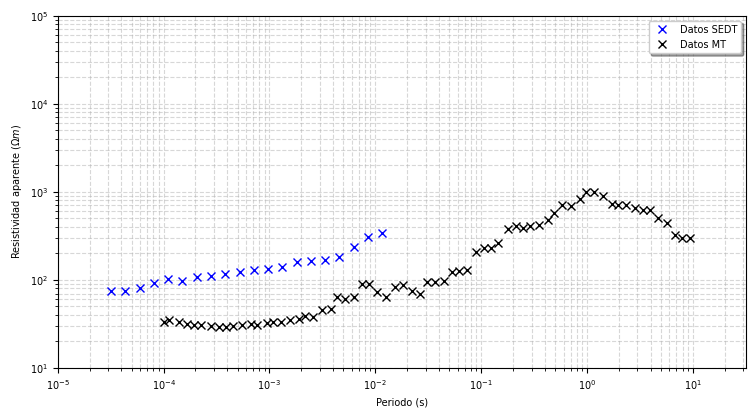

In [36]:
# Crear la figura y los subgráficos
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])  # 2 filas, 1 columna

# Gráfico superior: Resistividad aparente
ax0 = fig.add_subplot(gs[0])
ax0.loglog(1/f1, rhoa_TDEM, "blue", label='Datos SEDT',marker="x", lw=2, linestyle='none')
ax0.loglog(1/frecuencias, rho_app, color='black', label='Datos MT', marker="x", lw=2, linestyle='none')

# Configuración del gráfico de resistividad aparente
ax0.set_ylim([10**1, 10**5])
ax0.set_xlim([10**-5, 10**1.5])
ax0.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
ax0.set_ylabel("Resistividad aparente ($\Omega m$)")
ax0.set_xlabel("Periodo (s)")
ax0.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
plt.savefig("MTStaticShiftPiedecuesta.svg", dpi=300, bbox_inches='tight', format='svg')

In [37]:
#Asignar incertidumbres a los datos

uncertaintiesTDEM = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

uncertaintiesMT = np.abs(phase) * 0.05

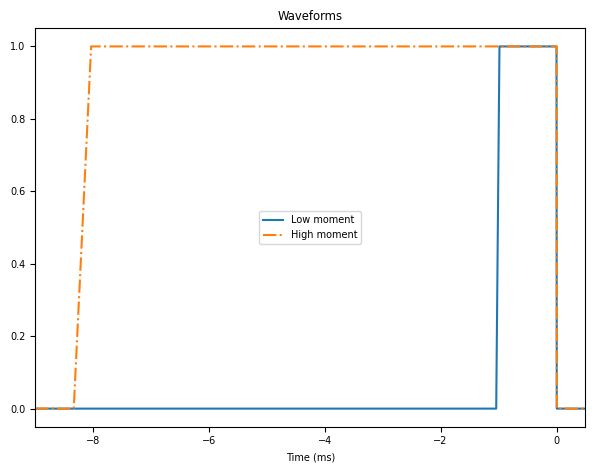

In [38]:
  # Low moment
lm_waveform_times = np.r_[-1.041E-03, -9.850E-04, 0.000E+00, 4.000E-06]
lm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

# High moment
hm_waveform_times = np.r_[-8.333E-03, -8.033E-03, 0.000E+00, 5.600E-06]
hm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

plt.figure()
plt.title('Waveforms')
plt.plot(np.r_[-9, lm_waveform_times*1e3, 2], np.r_[0, lm_waveform_current, 0],
         label='Low moment')
plt.plot(np.r_[-9, hm_waveform_times*1e3, 2], np.r_[0, hm_waveform_current, 0],
         '-.', label='High moment')
plt.xlabel('Time (ms)')
plt.xlim([-9, 0.5])
plt.legend()
plt.show()

waveform_LM = tdem.sources.PiecewiseLinearWaveform(
    times=lm_waveform_times, currents=lm_waveform_current
)

waveform_HM = tdem.sources.PiecewiseLinearWaveform(
    times=hm_waveform_times, currents=hm_waveform_current
)

In [39]:
# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.0])
receiver_orientation = "z"  # "x", "y" or "z"
times = tiempo.copy()
# Source properties

source_location = np.array([
    [-20, -20, 0], # Vértice 1 (punto de inicio)
    [20, -20, 0],
    [20, 20, 0],
    [-20, 20, 0],
    [-20, -20, 0]
])

receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    ),)

# Define source list. In our case, we have only a single source.
source_list = [tdem.sources.LineCurrent(
        receiver_list=receiver_list[:1],
        location=source_location,
        waveform=waveform_HM,),             
]

# Define the survey
survey = tdem.Survey(source_list)

In [40]:
receivers_list = [
    nsem.receivers.PointNaturalSource(component="phase")
    ]

source_list = []
for freq in frecuencias:
    source_list.append(nsem.sources.Planewave(receivers_list, freq))
        
surveyMT = nsem.survey.Survey(source_list)

In [41]:
# Definir los datos
data_objectMT = data.Data(surveyMT, dobs=phase, standard_deviation=uncertaintiesMT)
data_objectTDEM = data.Data(survey, dobs=-dobs, standard_deviation=uncertaintiesTDEM)

In [42]:
# Correr inversión de MT
dz = 8
n_layer = 20
z_factor = 1.34
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]

print(f"El espesor total del modelo será: {layer_thicknesses_inv.sum():.2f} metros")

# Malla
mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
mesh_inv

El espesor total del modelo será: 6094.37 metros


TensorMesh: 20 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20     -6,102.37          0.00      8.00  1,552.30    1.34

In [43]:
# Definir modelo inicial

rho_0 = 100 #100
rho_ref = 100 #100

# Modelo inicial
m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)

# Modelo de referencia
mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref) 

In [44]:
# Definir la física

sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)

simulationMT = nsem.simulation_1d.Simulation1DRecursive(
    survey=surveyMT, 
    sigmaMap=sigma_map,
    thicknesses=layer_thicknesses_inv,
    )

simulationTDEM = tdem.Simulation1DLayered(
    survey=survey,
    sigmaMap=sigma_map,
    thicknesses=layer_thicknesses_inv,
)

In [45]:
# Definir el desajuste de los datos
dmisMT = data_misfit.L2DataMisfit(simulation=simulationMT, data=data_objectMT)
dmisTDEM = data_misfit.L2DataMisfit(simulation=simulationTDEM, data=data_objectTDEM)

dmis = dmisMT + dmisTDEM

In [46]:
# Definir la regularización
reg = regularization.Sparse(
    mesh_inv, alpha_s=1e-10, alpha_x=1e-5, reference_model=mref, mapping=maps.IdentityMap(mesh=mesh_inv))

In [47]:
# Definir la optimización
opt = optimization.InexactGaussNewton(maxIter=20, maxIterCG=50)

In [48]:
# Definir el problema inverso
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [49]:
# Define un valor inicial para el parámetro de compensación beta
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)

# Establece la tasa de reducción del parámetro de compensación beta
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=3)
save_dictionary = directives.SaveOutputDictEveryIteration()
save_dictionary.outDict = {}
    
# Configurar un criterio de parada para la inversión
#target_misfit = directives.TargetMisfit(chifact=1e-2)
precond = directives.UpdatePreconditioner()

directives_list = [
    starting_beta,
    beta_schedule,
    save_dictionary
    ]

In [50]:
# Combinar el problema inverso y las directivas
inv = inversion.BaseInversion(inv_prob, directives_list)

# Ejecutar la inversión
recovered_model = inv.run(m0)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.49e+09  1.70e+05  0.00e+00  1.70e+05    3.44e+04      0              
   1  2.49e+09  1.14e+05  1.20e-06  1.17e+05    4.40e+04      0              
   2  2.49e+09  2.44e+04  3.45e-06  3.30e+04    1.62e+04      0              
   3  4.98e+08  1.37e+04  3.11e-06  1.52e+04    1.01e+04      0              
   4  4.98e+08  7.20e+03  5.10e-06  9.73e+03    4.60e+03      0              
   5  4.98e+08  6.66e+03  3.00e-06  8.16e+03    4.38e+03      0       

Datos MT

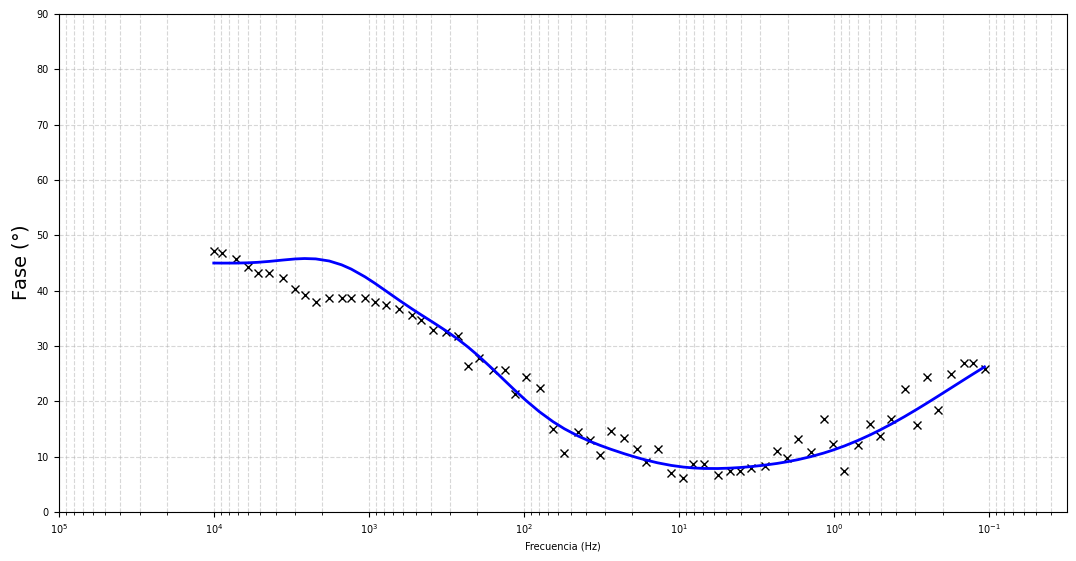

In [51]:
dpredMT= simulationMT.dpred(recovered_model)

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 5, figure=fig)

# Segundo subplot: Datos observados y predichos
ax = fig.add_subplot(gs[0, 2:])
ax.semilogx(frecuencias, phase, color='black', label="Fase MT", marker="x", lw=2, linestyle='none')
ax.semilogx(frecuencias, dpredMT, 'b-', label="Respuesta MT", lw=2)

ax.set_xlabel("Frecuencia (Hz)")
ax.set_xlim(frecuencias.max(), frecuencias.min())
ax.grid(True, which="both", linestyle='--', alpha=0.5) 
ax.set_ylabel("Fase ($\degree$)", fontsize=14)
ax.set_ylim(0, 90)
ax.set_xlim([10**5, 10**-1.5])

plt.show()

Datos SEDT

In [52]:
dpredTDEM = simulationTDEM.dpred(recovered_model)

In [53]:
dpredTDEM.shape

(20,)

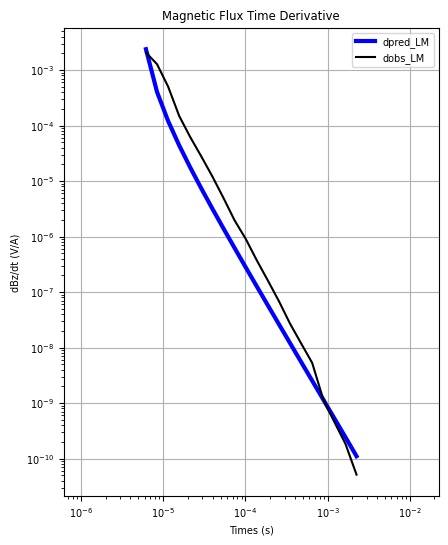

In [54]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, -dpredTDEM, "b-", lw=3, label='dpred_LM')

ax.loglog(tiempo, dobs, "k-",  label='dobs_LM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [55]:
from pygimli.physics.em import rhoafromU

In [56]:
rhoaTDEM = rhoafromU(U= -dpredTDEM, t= times, Tx= 1600, Rx= 1)

In [57]:
fdpred = 0.194 / times

Modelo del subsuelo

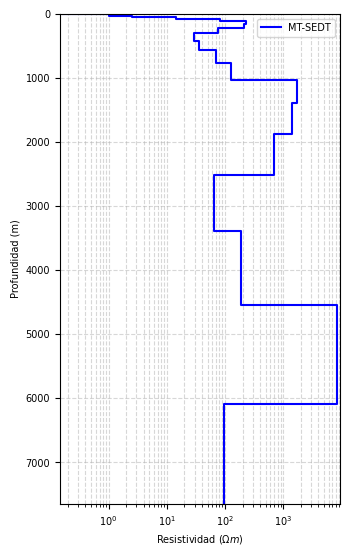

In [58]:
# Plot true model and recovered model
fig = plt.figure(figsize=(4, 7))


ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
#plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax1, color="k", label = "Teórico")
plot_1d_layer_model(
    layer_thicknesses_inv[::-1], (1/(sigma_map*recovered_model))[::-1], ax=ax1, color="b", label = "MT-SEDT"
)
ax1.grid()
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.set_ylabel(r"Profundidad (m)")
#x_min, x_max = 1/true_conductivities.min(), 1/true_conductivities.max()
#ax1.set_xlim(1e0, 1e3)
#ax1.set_ylim([6500, 0])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
ax1.legend()
filename = "MT-SEDT.png"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')


plt.show()

Respuesta MT

In [59]:
def run_forward(layerthicknesses, rho_layers, frecuencias_ok, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layerthicknesses, layerthicknesses[-1]])], "N")

    #mesh_plot = mesh.plot_grid() ###

    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


    sigma_map = maps.ExpMap(nP=len(rho_layers))

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frecuencias:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    ### CORRECCIÓN ---
    survey = nsem.survey.Survey(source_list) ### Antes -> survey = nsem.survery.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layerthicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frecuencias), 2))[:,0]
    phase = dpred.reshape((len(frecuencias), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs_rhoaMT = dpred + noise
    return dobs_rhoaMT, dpred

In [60]:
layerthicknesses = layer_thicknesses_inv[::-1]
rho_layers = (1/(sigma_map*recovered_model))[::-1]
relative_error_rho = 0.02
floor_phase = 2
dobs_rhoaMT, dpred = run_forward(layerthicknesses, rho_layers, frecuencias, relative_error_rho=relative_error_rho, floor_phase=floor_phase)

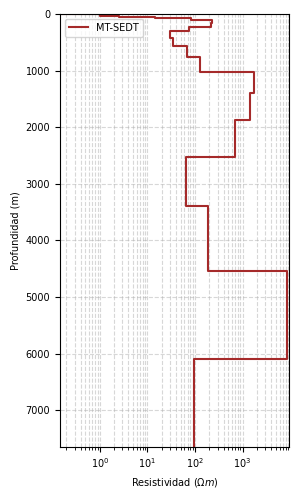

In [61]:
# --- Figura 1: Modelo 1D ---
plt.figure(figsize=(3, 5))  # Formato vertical

plot_1d_layer_model(
    layer_thicknesses_inv[::-1], 
    (1/(sigma_map*recovered_model))[::-1], 
    ax=plt.gca(), 
    color="brown", 
    label="MT-SEDT"
)

plt.xlabel(r"Resistividad ($\Omega m$)")
plt.ylabel("Profundidad (m)")
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

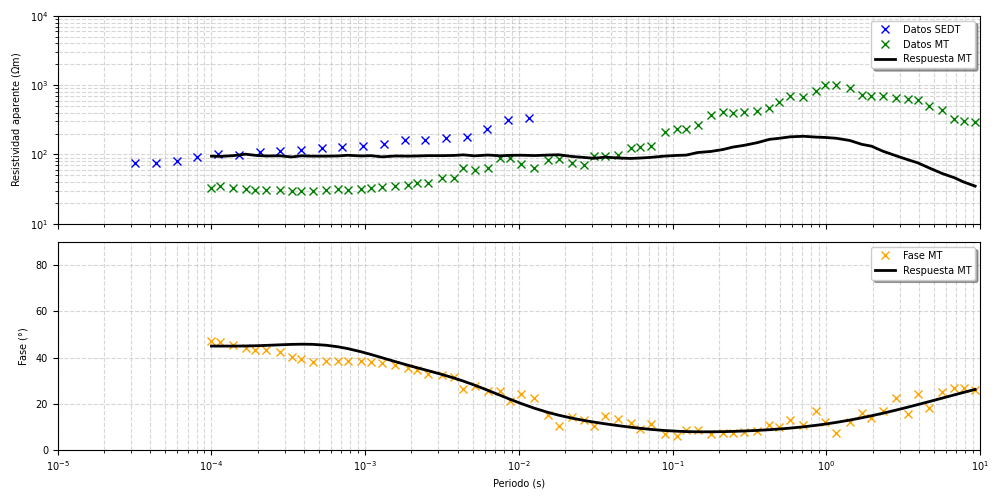

In [62]:
# --- Figura 2: Resistividad y fase ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)  # 2 subplots apilados

# --- Resistividad aparente (ax1) ---
ax1.loglog(1/f1, rhoa_TDEM, "blue", marker='x', linestyle='none', label='Datos SEDT', lw=2)
ax1.loglog(1/frecuencias, rho_app, marker='x', linestyle='none', color='green', label='Datos MT', lw=2)
ax1.loglog(1/frecuencias, dobs_rhoaMT.reshape((len(frecuencias), 2))[:, 0], color='black', label="Respuesta MT", lw=2)

ax1.set_ylabel("Resistividad aparente ($\Omega$m)")
ax1.set_ylim([10**1, 10**4])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)
ax1.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)

# --- Fase (ax2) ---
ax2.semilogx(1/frecuencias, phase, marker='x', linestyle='none', color='orange', lw=2, label="Fase MT")
ax2.semilogx(1/frecuencias, dpredMT, color='black', label='Respuesta MT', lw=2)
#ax2.loglog(1/frecuencias, dobs_rhoaMT.reshape((len(frecuencias), 2))[:, 1], color='black', label="Respuesta MT", lw=2)

ax2.set_xlabel("Periodo (s)")
ax2.set_ylabel("Fase ($\degree$)")
ax2.set_yticks(range(0, 90, 20))
ax2.set_ylim(0, 90)
ax2.grid(True, which="both", linestyle='--', alpha=0.5)
ax2.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)

plt.xlim([10**-5, 10**1])
plt.tight_layout()
plt.show()

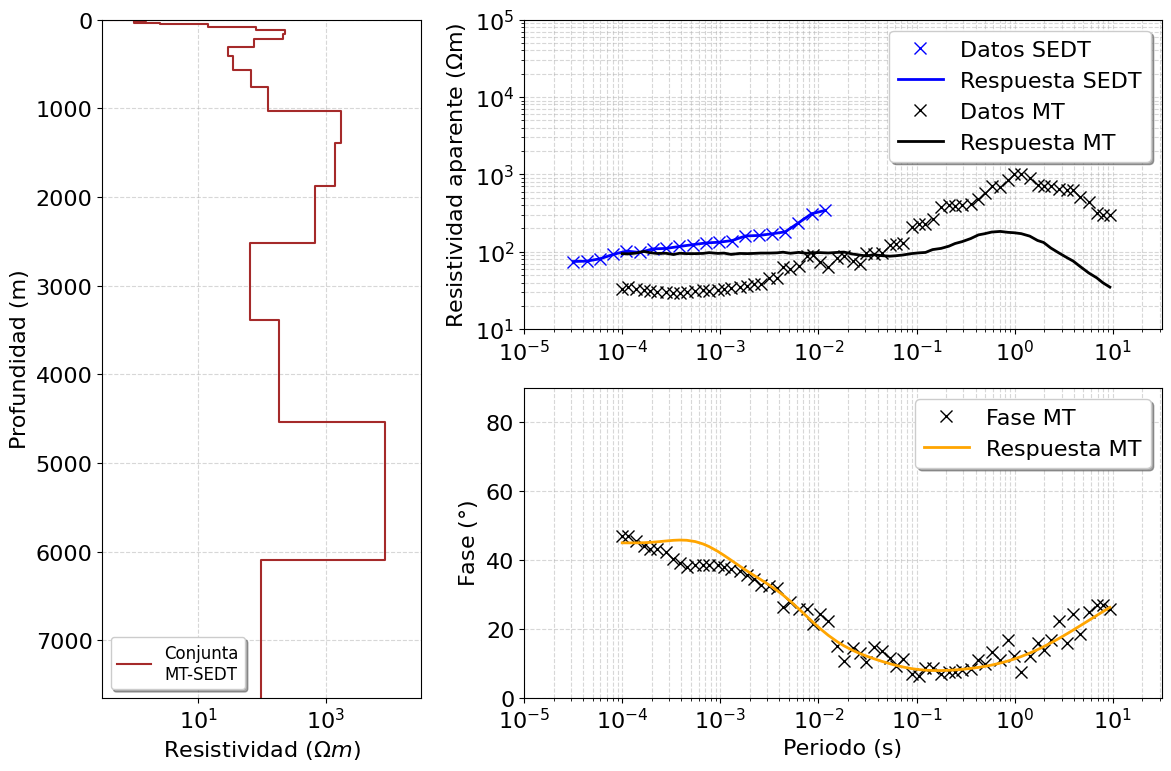

In [87]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig = plt.figure(figsize=(12, 8))  # Ajuste del tamaño para un modelo más largo
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 2], height_ratios=[1,1])

# --- Izquierda: Modelo 1D de resistividades ---
ax1 = fig.add_subplot(gs[:2, 0])  # Modelo ocupa más espacio verticalmente

plot_1d_layer_model(
    layer_thicknesses_inv[::-1], (1/(sigma_map*recovered_model))[::-1], ax=ax1, color="brown", label="Conjunta\nMT-SEDT"
)
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.set_ylabel("Profundidad (m)")
ax1.set_xlim([10**-0.5, 10**4.5])
#ax1.set_ylim([6500, 0])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)
ax1.legend(loc='lower left', frameon=True, shadow=True, fancybox=True, fontsize=12)

# --- Derecha arriba: Resistividad aparente ---
ax2 = fig.add_subplot(gs[0, 1])  # Más espacio para resistividad
ax2.loglog((1/f1), rhoa_TDEM, "blue", marker='x', markersize=8, linestyle='none', label='Datos SEDT', lw=2)
ax2.loglog((1/fdpred), rhoa_TDEM, "b-", label='Respuesta SEDT', lw=2)
ax2.loglog(1/frecuencias, rho_app, marker='x', markersize=8,linestyle='none', color='black', label='Datos MT', lw=2)
ax2.loglog(1/frecuencias, dobs_rhoaMT.reshape((len(frecuencias), 2))[:, 0], color='black', label="Respuesta MT", lw=2)
ax2.set_ylim([10**1, 10**5])
ax2.set_xlim([10**-5, 10**1.5])
ax2.set_ylabel("Resistividad aparente ($\Omega$m)")
ax2.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
ax2.grid(True, which="both", linestyle='--', alpha=0.5)

# --- Derecha abajo: Fase ---
ax3 = fig.add_subplot(gs[1, 1])  # Menos espacio para fase
ax3.semilogx(1/frecuencias, phase, marker='x',markersize=8, linestyle='none', color='black', lw=2, label="Fase MT")
ax3.semilogx(1/frecuencias, dpredMT, color='orange', label='Respuesta MT', lw=2)
ax3.set_xlabel("Periodo (s)")
ax3.set_ylabel("Fase ($\degree$)")
ax3.set_yticks(range(0, 90, 20))
ax3.set_ylim(0, 90)
ax3.set_xlim([10**-5, 10**1.5])
ax3.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
ax3.grid(True, which="both", linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("MT-SEDT_real.svg", dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [80]:
# Calcular el desplazamiento estático

s = np.mean(rho_app[:20] / dobs_rhoaMT.reshape((len(frecuencias), 2))[:, 0][:20])

print(f"Desplazamiento s = {s:.3f}")

Desplazamiento s = 0.343


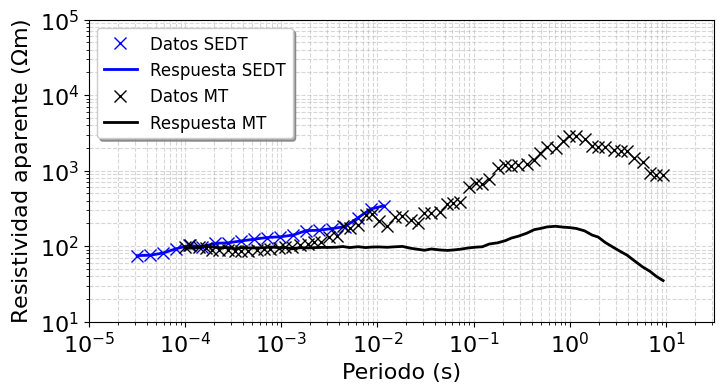

In [89]:

fig = plt.figure(figsize=(12, 8)) 

# --- Derecha arriba: Resistividad aparente ---
ax2 = fig.add_subplot(gs[0, 1])  # Más espacio para resistividad
ax2.loglog((1/f1), rhoa_TDEM, "blue", marker='x', markersize=8, linestyle='none', label='Datos SEDT', lw=2)
ax2.loglog((1/fdpred), rhoa_TDEM, "b-", label='Respuesta SEDT', lw=2)
ax2.loglog(1/frecuencias, (1/s)*rho_app, marker='x', markersize=8,linestyle='none', color='black', label='Datos MT', lw=2)
ax2.loglog(1/frecuencias, dobs_rhoaMT.reshape((len(frecuencias), 2))[:, 0], color='black', label="Respuesta MT", lw=2)
ax2.set_ylim([10**1, 10**5])
ax2.set_xlim([10**-5, 10**1.5])
ax2.set_ylabel("Resistividad aparente ($\Omega$m)")
ax2.set_xlabel("Periodo (s)")
ax2.legend(loc='upper left', frameon=True, shadow=True, fancybox=True,  fontsize=12)
ax2.grid(True, which="both", linestyle='--', alpha=0.5)
plt.savefig("MT_real_ajustados.svg", dpi=300, bbox_inches='tight', format='svg')